Installations and Imports:

In [1]:
!pip install rdkit-pypi
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install -q path
!pip install torchmetrics

import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint, sample

from rdkit import Chem
from rdkit.Chem import Descriptors as D
from rdkit.ML.Descriptors import MoleculeDescriptors as MD

import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torchvision.transforms import Compose
from torch_geometric.utils import to_networkx
from torch_geometric.transforms import NormalizeScale

from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression

import xgboost as xgb
from sklearn.svm import SVR as svm
from sklearn.ensemble import RandomForestRegressor as rdf

!pip install mlxtend  
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some common parameters for all code:

In [44]:
# Targets and corresponding ChEMBL file
files = {
    'E_COLI':'E_COLI.csv',
    'E_COLI_PROT':'E_COLI_PROT.csv',
    'P_AERUGINOSA':'P_AERUGINOSA.csv',
    'P_AERUGINOSA_PROT':'P_AERUGINOSA_PROT.csv',
    'S_AUREUS':'S_AUREUS.csv',
    'S_AUREUS_PROT':'S_AUREUS_PROT.csv'
}
# Columms of interest from ChEMBL files
col = {
    'WEIGHT':'Molecular Weight',
    'RO5':'#RO5 Violations',
    'SMILES':'Smiles',
    'TYPE':'Standard Type',
    'RELATION':'Standard Relation',
    'VALUE':'Standard Value',
    'UNITS':'Standard Units'
}
# Columms of interest data types from ChEMBL files
types = {
    'WEIGHT':float,
    'RO5':int,
    'SMILES':str,
    'TYPE':str,
    'RELATION':str,
    'VALUE':float,
    'UNITS':str
}

# Paths for data loading and saving
paths = {
    'root_path':'/content/drive/My Drive/TFM - Juan Vigueras Diaz/DEV/',
    'raw_data_path': '/content/drive/My Drive/TFM - Juan Vigueras Diaz/DEV/DATA_RAW/',
    'path_dataframes': '/content/drive/My Drive/TFM - Juan Vigueras Diaz/DEV/DATA_FRAMES/',
    'path_dataloaders': '/content/drive/My Drive/TFM - Juan Vigueras Diaz/DEV/DATA_LOADERS/',
    'path_dataloaders_75': '/content/drive/My Drive/TFM - Juan Vigueras Diaz/DEV/DATA_LOADERS_75/',
    'path_descriptors_raw': '/content/drive/My Drive/TFM - Juan Vigueras Diaz/DEV/DESCRIPTORS/RAW/',
    'path_descriptors': '/content/drive/My Drive/TFM - Juan Vigueras Diaz/DEV/DESCRIPTORS/'
}

# Provisional Descriptors
descriptors = ['MaxEStateIndex',
 'MinEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'HallKierAlpha',
 'Ipc',
 'Kappa3',
 'LabuteASA',
 'TPSA',
 'FractionCSP3',
 'HeavyAtomCount',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',
 'MolLogP',
 'MolMR']

## Carga de Datos Raw y Selección de Columnas

Carga de todos los archivos ChEMBL en un único dataset con las columnas pertinentes.

Para unificar las medidas en las mismas unidades, se ha de hacer el siguiente cálculo:

$(MW = Molecular Weight, KD=KiloDalton)$


$\mu M = (\frac{\mu g}{mL}) / (MW [KD])$ 

$MW[KD] = MW[\frac{g}{mol}]·10^{-3}$

$n M = 10^{-3} \mu M$ 

Finalmente queda como:

$VALUE[nM] = \frac{VALUE [\mu g·mL^{-1}]}{MW [g·mol^{-1}]}$ 

Aunque en la columna de Peso se indica "Molecular Weight", realmente es el peso molar en g/mol.

In [45]:
def create_dataset(files):
  # Create a full dataset from ChEMBL files
  li = []
  for filename in files: # For all CSV available:
      df = pd.read_csv(paths['raw_data_path']+files[filename], 
                       sep=";", 
                       usecols=list(col.values()),
                       low_memory=False) # Read CSV
      df['TARGET'] = filename # Assign new col with target name
      df = df[df[col['RELATION']]=="'='"] # Select only equal measure relation
      df = df.replace('None','0').dropna() # Replace None values and drop NaN
      li.append(df)
  dataset = pd.concat(li, axis=0, ignore_index=True) # Concat all CSV dataframes
  dataset = dataset.apply(pd.to_numeric, errors='ignore') # Redefine col dtypes
  # Assign a new column with 'TARGET' value from file name
  dataset.set_axis(list(col.keys())+['TARGET'], axis=1, inplace=True)
  return dataset

def align_units(dataset, unit):
  # Creates new column based on specified unit. For now, only nM is available
  if unit=="nM":
    dataset['VALUE_NM'] = np.where(dataset['UNITS']=='ug.mL-1', # if
                                   dataset['VALUE']/dataset['WEIGHT'], # then 
                                   dataset['VALUE']) # else
  return dataset

def drop_duplicates(dataset):
  # Drops duplicated rows in terms of TARGET-SMILES tuple, which comes from 
  # different experimental approaches of computing the indicator's value.
  # It keeps de lowest value for 'VALUE_NM' indicator, i.e., the value related
  # to the  highest bioactivity.
  dataset = dataset.rename_axis('index').reset_index() \
          .sort_values(['TARGET','SMILES','VALUE_NM']) \
          .drop_duplicates(['TARGET','SMILES'], keep='first') \
          .set_index('index').rename_axis(dataset.index.name) \
          .reset_index(drop=True)
  return dataset

In [46]:
dataset = drop_duplicates(align_units(create_dataset(files),'nM'))

In [47]:
dataset

,WEIGHT,RO5,SMILES,TYPE,RELATION,VALUE,UNITS,TARGET,VALUE_NM
0,740.80,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCCCCCn2ccc(=NCC...,MIC,'=',1.0,ug.mL-1,E_COLI,0.001350
1,712.74,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCCCn2ccc(=NCC(C...,MIC,'=',0.4,ug.mL-1,E_COLI,0.000561
2,698.72,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCCn2ccc(=NCC(CC...,MIC,'=',1.0,ug.mL-1,E_COLI,0.001431
3,684.69,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCn2ccc(=NCC(CC)...,MIC,'=',1.0,ug.mL-1,E_COLI,0.001461
4,670.66,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCn2ccc(=NCC(CC)C...,MIC,'=',3.9,ug.mL-1,E_COLI,0.005815
...,...,...,...,...,...,...,...,...,...
80141,234.31,0,O=c1[nH]cnc2scc(-c3cccs3)c12,IC50,'=',50000.0,nM,S_AUREUS_PROT,50000.000000
80142,371.43,0,O=c1cc(-c2ccccc2)c2c(-c3cnc(-c4cccnc4)s3)n[nH]...,IC50,'=',1315.0,nM,S_AUREUS_PROT,1315.000000
80143,295.33,0,O=c1ccc2c(-c3cnc(-c4cccnc4)s3)n[nH]c2[nH]1,IC50,'=',270.0,nM,S_AUREUS_PROT,270.000000
80144,339.38,0,O=c1ccc2c(-c3cnc(-c4cccnc4)s3)n[nH]c2n1CCO,IC50,'=',564.0,nM,S_AUREUS_PROT,564.000000


In [48]:
'''
Instruction to store the previous raw dataset in Google Drive
'''
dataset.to_csv(paths['root_path']+'DATASET_RAW.csv',index=False)

In [ ]:
# Full list of available Molecular Descriptors:
[x[0] for x in D._descList]

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_

## Cálculo Grafos - Dataset para DL / Descriptores Moleculares - Dataset para ML

### Definición de Clases

In [51]:
class Molecules():
  '''
  Molecules class takes a set of molecules in smiles format.
  It computes molecules characteristics related to the made up atoms, their 
  chemical species and weighted labeled encoding, the pairs of boundings
  and their chemical labelled type.
  It includes two methods:
  · unique_atoms(), which returns a dictionary of the weighted labeled encoding
  for each different atom found in the dataset.
  · compute_structures(), which returns two list of lists for atoms and bounds.
  '''
  def __init__(self, smiles):
    self.smiles = smiles
    self.mols = [Chem.MolFromSmiles(i) for i in smiles]
    self.molblocks = [Chem.MolToMolBlock(Chem.AddHs(i)).split("\n") for i in self.mols]
    max_len = len(max(self.smiles,key=len))*2 # Control value for CHEM Mol tables that generates error
    control_list = ["",0] # List control for CHEM MOL tables that generates error
    # List of number of atoms and number of bounds for each molecule.
    # 0 value is associated if error is found in CHEM Mol table
    self.num_atoms = [0 if i[3].split(" ")[1] in control_list else 
                      0 if int(i[3].split(" ")[1])>max_len else 
                      int(i[3].split(" ")[1]) for i in self.molblocks]
    self.num_bounds = [0 if i[3].split(" ")[2] in control_list else 
                       0 if int(i[3].split(" ")[2])>max_len else 
                       int(i[3].split(" ")[2]) for i in self.molblocks]

  def unique_atoms(self):
    '---Creates a dictionary with weighted labeled encoded values for each atom species found---'
    unique_atoms = [] # List that contains ALL individual atoms in dataset
    for string in self.smiles:
      for atom in Chem.AddHs(Chem.MolFromSmiles(string)).GetAtoms(): # Getting atoms from SMILES
        unique_atoms.append(atom.GetSymbol()) # Adding atoms to list
    # Get unique atomas and their concurrence:
    u, count = np.unique(unique_atoms, return_counts=True) 
    unique_atoms = list(u[np.argsort(count)]) # Max number of concurrence
    # Dictonary of weighted unique values:
    dict_unique_atoms = dict(zip(unique_atoms,list(np.round(np.linspace(0,1,len(unique_atoms)),4))))
    return dict_unique_atoms

  def compute_structures(self):
    '---Creates two lists of lists of atoms and bounds characteristics for each molecule---'
    unique_atoms = self.unique_atoms()
    atoms = [] # List of all molecules features regarding atoms
    bounds = [] # List of all molecules features regarding bounds
    # For loop accross all molecules:
    for n_a, n_b, molblock in zip(self.num_atoms, self.num_bounds, self.molblocks):
      mol_atoms = [] # List for each molecule's atoms
      mol_bounds = [] # List for each molecule's bounds
      # For loop accross all MOL file rows corresponding to atoms:
      for fila in range(1,n_a+1): 
        row_a = list(filter(None,molblock[fila+3].split(" "))) # Selection of the row
        # Ciordinates are selected, as well as atom type and its weighted label from dictionary
        mol_atoms.append([[float(row_a[0]),float(row_a[1])], row_a[3], unique_atoms[row_a[3]]])
      # For loop accross all MOL file rows corresponding to bounds:
      for fila in range(1+n_a,n_a+1+n_b):
        row_b = list(filter(None,molblock[fila+3].split(" "))) # Selection of the row
        # Pair of atoms that shapes the bound is selected, as well as bound type
        mol_bounds.append([[float(row_b[0]),float(row_b[1])], float(row_b[2])]) 
      atoms.append(mol_atoms)
      bounds.append(mol_bounds)
    return atoms, bounds

class Descriptors():
  '''
  Descriptors class takes a set of molecules in smiles format.
  It computes molecules descriptors calling Molecules class.
  It includes one method:
  · compute_descriptors(descriptors_list), which takes the list of molecular
  descriptors to compute and returns a pandas 'dataframe' table with one 
  row per molecule, and one column for each molecular descriptor.
  '''
  def __init__(self, smiles):
      self.smiles = smiles
      self.Molecules = Molecules(self.smiles)

  def compute_descriptors(self, descriptors_list=[x[0] for x in D._descList]):
    '---Create a DataFrame of Mol. Descriptors with molecules structure info.---'
    mols = self.Molecules.mols
    rdkit_md = [] # General list that will feed the DataFrame object
    calc = MD.MolecularDescriptorCalculator(descriptors_list)
    header = calc.GetDescriptorNames() # Header for the dataframe
    # Loop across every molecule:
    for i in range(len(mols)): 
        # Compute descriptors, returns a list that corresponds to a DF row:
        ds = calc.CalcDescriptors(mols[i]) 
        rdkit_md.append(ds) # Adding the list (row) to the general list
    # Create a dataframe from general list and header:
    df = pd.DataFrame(rdkit_md,columns=header)
    return df

class Graphs():
  '''
  Graphs class takes a set of molecules in smiles format.
  It computes molecules structures (bounds and edges) calling Molecules class.
  It includes two methods:
  · compute_graphs(), which returns a list of Data PyG objects from molecules.
  · plot_molecule(), which returns a plot of the index-selected molecule.
  '''
  def __init__(self, smiles):
      self.smiles = smiles
      self.Molecules = Molecules(self.smiles)

  def compute_graphs(self, norm=True):
    '---Create a list of Data structure with molecules structure info.---'
    atoms, bounds = self.Molecules.compute_structures()
    def norm_coord(tensor):
      '---Normalize a 2D tensor coordinates between -1 and 1---'
      min_x = min(tensor[:,0])
      max_x = max(tensor[:,0])
      min_y = min(tensor[:,1])
      max_y = max(tensor[:,1])
      tensor[:,0] = 2*(tensor[:,0]-min_x)/(max_x-min_x)-1
      tensor[:,1] = 2*(tensor[:,1]-min_y)/(max_y-min_y)-1
      return tensor
    index = list(range(0,len(atoms)))
    data_list = []
    index_list = []
    # Loop across every pack of atoms & bounds (one par molecule)
    for serie_atoms, serie_bounds, index in zip(atoms, bounds, index):
      if len(serie_atoms)!=0:
        index_list.append(index)
        # Coordinates (x,y):
        pos = torch.tensor([item[0] for item in serie_atoms])       
        norm_coord(pos) if norm==True else pos # Normalize if specified
        # Node features (numeric encoded label):
        x =  torch.tensor([[item[2]] for item in serie_atoms])
        # Edge index:
        edge_index = torch.tensor([item[0] for item in serie_bounds]).t().contiguous()
        '''By default, we don't get bi-directional edges from bounds.
        We implement this foor loop to add cross-paired bounds to edge tensor'''
        if len(edge_index)!=0: # Control for empty tensors
          for a,b in zip(edge_index[0],edge_index[1]):
            edge_index = torch.cat((torch.tensor([[b],[a]]), edge_index),1)
        # Sub-list of structure elements:
        data = [x, edge_index, pos]
        data_list.append(data)
    return data_list, index_list

  def plot_molecule(self,
                    molecule, # Index from molecule in SMILES list of elements
                    labeled=True, # Plot with edges or without them
                    grid=True): # Plot with grid or without it
    '---Plots a molecule by a given index.---'
    # Elements needed to represent, directly obtained from Molecules class:
    atoms, bounds = self.Molecules.compute_structures()
    pos_raw = [item[0] for item in atoms[molecule]]
    pos_raw_feat = [item[1] for item in atoms[molecule]]
    edge_index_raw = [item[0] for item in bounds[molecule]]
    edge_index_raw_feat = [item[1] for item in bounds[molecule]]

    '---DEFINE GRAPHS, RAW POINTS AND RAW EDGES---'
    G = nx.Graph()
    # Points and Edges must be converted to lists of tuples for further treatment:
    points = [tuple(x) for x in pos_raw]  # (x,y)
    edges = [tuple(x) for x in [[x-1,y-1] for [x,y] in edge_index_raw]] # (v1,v2)

    '---DEFINE POINTS TO BE DRAWN---'
    pos = {point: point for point in points} # Nodes must be in dictonary form

    '---DEFINE BOUNDS AND BOUND LABELS---'
    # Double bound is marked as "=" and simple bound remains unlabelled
    bounds = ["" if bound==1 else "=" if bound==2 else "~" 
              for bound in edge_index_raw_feat]
    for i in range(len(edges)): # Definition of edges inside the Graph object
        G.add_edge(points[int(edges[i][0])], 
                  points[int(edges[i][1])], 
                  weight=bounds[i])
    
    '---DEFINE FIGURE AND PLOT---'
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 10)

    '---DRAW NODES AND EDGES---'
    atoms = pos_raw_feat
    # Dictionary of random generated colors for each different atom on the graph:
    color_dict = dict(zip(np.unique(atoms),
            ['#%06X'%randint(0,0xFFFFFF) for i in range(len(np.unique(atoms)))]))
    # Creation of color list corresponding to each atom on the graph:
    node_color = [color_dict[atom] for atom in atoms]
    nx.draw(G, 
            pos, 
            ax=ax,
            node_size=50,
            node_color=node_color) # Draw Nodes and Edges

    '---DRAW NODE LABELS---'
    # Get atom labels for each node in dictionary form (associating with pos(x,y))
    a_labels = {point: atom for point,atom in zip(points,atoms)}
    nx.draw_networkx_labels(G, 
                            pos, 
                            font_size=14, 
                            labels=a_labels, 
                            font_color='k',
                            verticalalignment="bottom")  # Draw node labels
    
    '---DRAW EDGE LABELS---'
    e_labels = nx.get_edge_attributes(G, 'weight') # Get edge labels
    nx.draw_networkx_edge_labels(G, 
                                pos, 
                                ax=ax,
                                font_size=20, 
                                edge_labels=e_labels) # Draw edge labels
    
    '---PLOT CHARACTERISTICS---'
    plt.axis("on")
    plt.grid(True, alpha=0.9) if grid==True else plt.grid(True, alpha=0)
    ax.tick_params(labelleft=labeled, labelbottom=labeled)
    plt.show()

class Descriptor_Dataset():
  '''
  Desriptor_Dataset class takes a set of molecules in smiles format, a list of
  the target indicator's values and a list of molecular descriptors to compute.
  It computes molecules descriptors calling Descriptors() class, then it builds
  three subsets of training, validation and test.
  It includes two methods:
  · compute_graphs(), which returns the three subsets of train, validation and
  test in DataFrame format with 80, 10 and 10% of the original data respectively.
  '''
  def __init__(self, smiles, target, md_list):
    self.smiles = smiles
    self.target = target
    self.md_list = md_list
    self.Descriptors = Descriptors(self.smiles)
      
  def create_dataset(self):
    dataset = self.Descriptors.compute_descriptors(list(self.md_list))
    dataset['VALUE_NM'] = self.target
    data_train, data_test = train_test_split(dataset, train_size=0.8)
    return data_train, data_test

class Graph_Dataset():
  '''
  Graphs class takes a set of molecules in smiles format.
  It computes molecules structures (bounds and edges) calling Molecules class.
  It includes two methods:
  · compute_graphs(), which returns a list of Data PyG objects from molecules.
  '''
  def __init__(self, smiles, target, batch_size=32):
    self.smiles = smiles
    self.full_target = target
    self.Graphs = Graphs(self.smiles)
    self.bs = batch_size
  
  def create_dataset(self):
    data = []
    graphs, indexs = self.Graphs.compute_graphs()

    sub_target = []
    for i in range(0,len(self.full_target)):
      if i in indexs:
        sub_target.append(self.full_target[i])

    for i in range(0,len(indexs)):
      # PyG object structure of Data:
      data.append(Data(x = torch.tensor(graphs[i][0]), 
                        edge_index = torch.tensor(graphs[i][1]), 
                        pos = torch.tensor(graphs[i][2]),
                        y = torch.tensor(sub_target[i])))
    
    data_train, data_rem = train_test_split(data, train_size=0.8)
    data_valid, data_test = train_test_split(data_rem, test_size=0.5)
    
    train = DataLoader(data_train, batch_size=self.bs, shuffle=True)
    valid = DataLoader(data_valid, batch_size=self.bs, shuffle=True)
    test = DataLoader(data_test, batch_size=1, shuffle=True)
    return train, valid, test, indexs

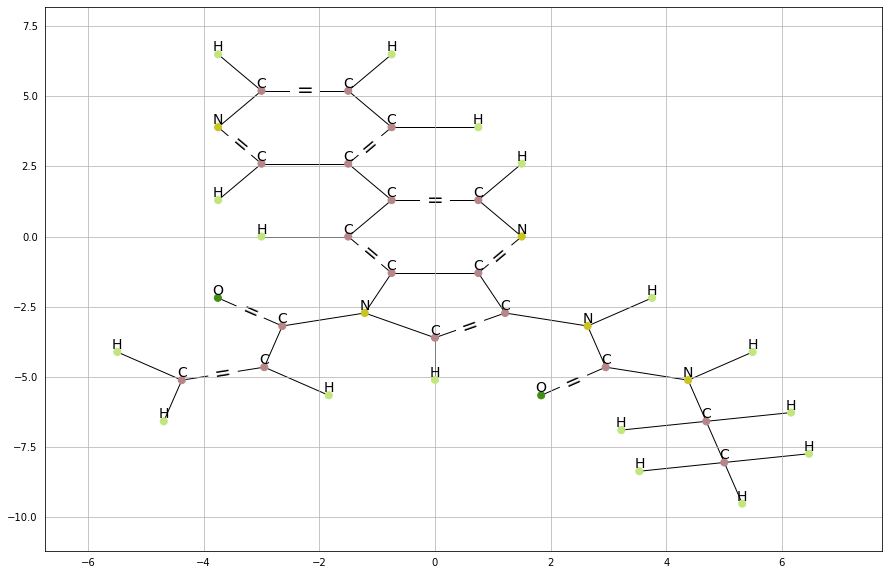

In [ ]:
Graphs([list(dataset[(dataset['TARGET']=='S_AUREUS_PROT')]['SMILES'])[2]]).plot_molecule(0)

### Feature Selection

In [ ]:
'''
On first hand, all molecular descriptors are computed for every target-indicator
tuple. These dataframes are stored in .CSV files.
'''

for target in files: # Loop for target
  for indicator in ['MIC', 'IC50']: # Loop for indicator
    try: # Try clausule since not all tuples target-indicator are considered
      print("Calculando descriptores para: ", target, indicator)
      # compute_descriptors() function from Descriptors() class is used:
      descriptors_full = Descriptors(list(dataset[(dataset['TARGET']==target) & 
                                                  (dataset['TYPE']==indicator)]['SMILES'])).compute_descriptors()
      # Result is stored in Google Drive:
      descriptors_full.to_csv(paths['path_descriptors_raw']+target+'_'+indicator+'_DESCRIPTORS_DATAFRAME.csv', 
                              sep=";", index=False)
    except:
      pass

Calculando descriptores para:  E_COLI MIC
Calculando descriptores para:  E_COLI IC50
Calculando descriptores para:  E_COLI_PROT MIC
Calculando descriptores para:  E_COLI_PROT IC50
Calculando descriptores para:  P_AERUGINOSA MIC
Calculando descriptores para:  P_AERUGINOSA IC50
Calculando descriptores para:  P_AERUGINOSA_PROT MIC
Calculando descriptores para:  P_AERUGINOSA_PROT IC50
Calculando descriptores para:  S_AUREUS MIC
Calculando descriptores para:  S_AUREUS IC50
Calculando descriptores para:  S_AUREUS_PROT MIC
Calculando descriptores para:  S_AUREUS_PROT IC50


Sin varianza nula: 37
E_COLI MIC | # Initial Selected Features:  20


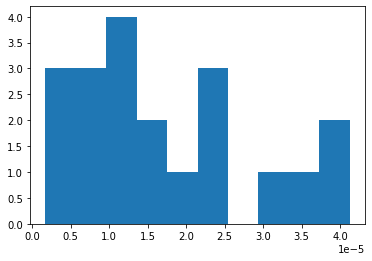

Entre 0 y 25%: 6
Entre 25% y 50%: 7
Entre 50% y 75%: 3
Mayor que 75%: 4
--------------------------------------------------
Sin varianza nula: 37
E_COLI IC50 | # Initial Selected Features:  19


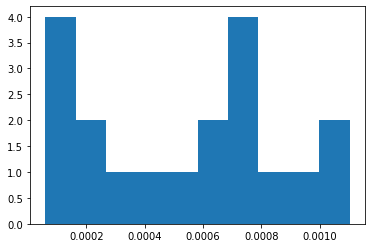

Entre 0 y 25%: 6
Entre 25% y 50%: 2
Entre 50% y 75%: 7
Mayor que 75%: 4
--------------------------------------------------
Sin varianza nula: 37
E_COLI_PROT IC50 | # Initial Selected Features:  20


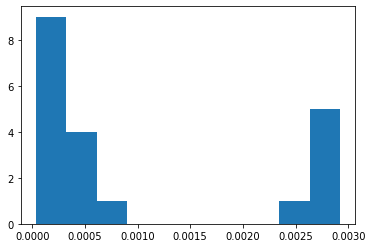

Entre 0 y 25%: 14
Entre 25% y 50%: 0
Entre 50% y 75%: 0
Mayor que 75%: 6
--------------------------------------------------
Sin varianza nula: 38
P_AERUGINOSA MIC | # Initial Selected Features:  19


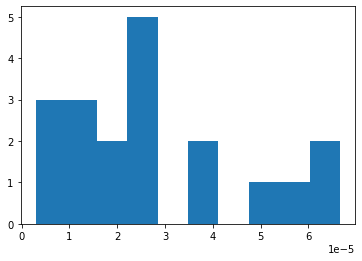

Entre 0 y 25%: 7
Entre 25% y 50%: 6
Entre 50% y 75%: 3
Mayor que 75%: 3
--------------------------------------------------
Sin varianza nula: 37
P_AERUGINOSA IC50 | # Initial Selected Features:  19


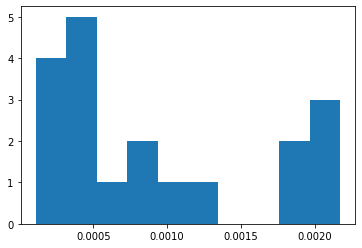

Entre 0 y 25%: 10
Entre 25% y 50%: 3
Entre 50% y 75%: 1
Mayor que 75%: 5
--------------------------------------------------
Sin varianza nula: 37
P_AERUGINOSA_PROT IC50 | # Initial Selected Features:  25


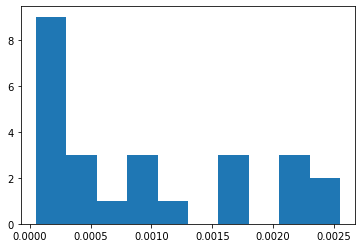

Entre 0 y 25%: 12
Entre 25% y 50%: 5
Entre 50% y 75%: 3
Mayor que 75%: 5
--------------------------------------------------
Sin varianza nula: 37
S_AUREUS MIC | # Initial Selected Features:  19


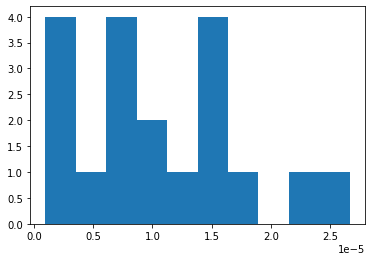

Entre 0 y 25%: 6
Entre 25% y 50%: 6
Entre 50% y 75%: 5
Mayor que 75%: 2
--------------------------------------------------
Sin varianza nula: 37
S_AUREUS IC50 | # Initial Selected Features:  19


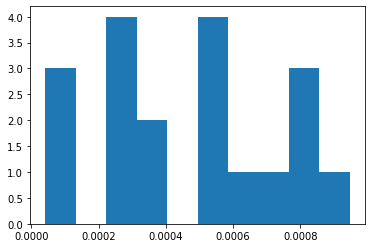

Entre 0 y 25%: 3
Entre 25% y 50%: 6
Entre 50% y 75%: 5
Mayor que 75%: 5
--------------------------------------------------
Sin varianza nula: 37
S_AUREUS_PROT IC50 | # Initial Selected Features:  20


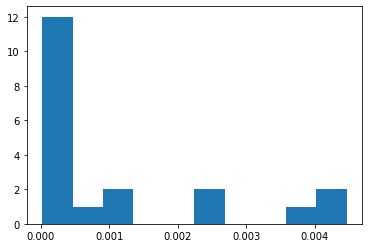

Entre 0 y 25%: 15
Entre 25% y 50%: 0
Entre 50% y 75%: 2
Mayor que 75%: 3
--------------------------------------------------


In [ ]:
'''
Feature Selection.

Three steps are performen in this section of code for each target-indicator tuple:
1. Fields are ruled out if their variance is zero.
2. Fields correlation is evaluated for each pair, and a field is ruled out if it 
has a >80% correlation with another field. Which one to choose from the pair is 
determined by the minimum value of p-value with the indicator (output) value.
3. Variance of normalized data is computed, and fields are ruled out if their
value is under the 20% of the maximum obtained.
'''
for target in files: # Loop for targets
  for indicator in ['MIC', 'IC50']: # Loop for indicators
    try:
      # ---------
      # Load Data
      # ---------
      y = dataset[(dataset['TARGET']==target) & (dataset['TYPE']==indicator)]['VALUE_NM'] # Target indicator field
      descriptors_full = pd.read_csv(paths['path_descriptors_raw']+target+'_'+indicator+'_DESCRIPTORS_DATAFRAME.csv',sep=";").fillna(0) # Full descriptor dataset
      descriptors_full = descriptors_full[descriptors_full.columns.intersection(descriptors)] # Pre-selected descriptors
      # -------------
      # Null Variance
      # -------------
      variance_instance = VarianceThreshold() # Feature selector class that removes all low-variance features
      variance_instance.fit_transform(descriptors_full) 
      concol = [column for column in descriptors_full.columns # Column retrieval from index 
          if column not in descriptors_full.columns[variance_instance.get_support()]]
      descriptors_full = descriptors_full.drop(concol,axis=1)
      print("Sin varianza nula:", len(descriptors_full.columns))
      # -----------
      # Correlation
      # -----------
      corr = descriptors_full.corr().fillna(0) # Correlation matrix
      columns = np.full((corr.shape[0],), True, dtype=bool) # Columns from correlation matrix
      for i in range(corr.shape[0]): # Loop for matrix rows, i-feature
        for j in range(i+1, corr.shape[0]): # Loop for matrix columns, j-feature
          if corr.iloc[i,j] >= 0.8: # Cell value of matrix
            if columns[j]: # Check if column still exists in list
              feature_selector = SelectKBest(f_regression, k="all") # Class for feature selection according to the k highest scores
              fit_i = feature_selector.fit(np.array(descriptors_full.iloc[:,i]).reshape(-1, 1),y).pvalues_ # i p-value
              fit_j = feature_selector.fit(np.array(descriptors_full.iloc[:,j]).reshape(-1, 1),y).pvalues_ # j p-value
              # Feature selection according to p-value
              # Maximum p-value feature is deleted from columns list:
              if fit_i <= fit_j:
                columns[j] = False
              else:
                columns[i] = False
      selected_columns = descriptors_full.columns[columns] # List of selected columns
      descriptors_selected = descriptors_full[selected_columns] # Redefinition of dataset
      print(target, indicator, "| # Initial Selected Features: ", len(descriptors_selected.columns))
      
      '''
      The following part of the code corresponds to the Exhaustive Feature Selection
      method from MLXTend package. This method is discarded because it would take
      more than 1e26 tests to complete only one tuple.
      '''
      '''
      for i, classifier in enumerate([xgb(verbosity=0),svm(verbose=0),rdf(verbose=0)]):
        classifiers = ['XGB','SVM','RDF']
        efs = EFS(classifier,
                  min_features=1,
                  max_features=len(descriptors_selected.columns),
                  scoring='neg_mean_squared_error',
                  print_progress=True)
        efs = efs.fit(descriptors_selected,y)
        selected_features = descriptors_selected.columns[list(efs.best_idx_)]
        print('Classifier:', classifiers[i])
        print("Selected Features:", selected_features)
        print(len(selected_features))
        print(efs.best_score)
        print('------------------------------------------')
      '''
      # ---------------------
      # Variance distribution
      # ---------------------
      variances = []
      for column in descriptors_selected:
        # Variance computing for each normalized column, then the value is added to variances list
        var = np.var(normalize(np.array(descriptors_selected[column]).reshape(1,-1)))
        variances.append(var)
      plt.hist(variances)
      plt.show()
      fifth_part = max(variances)/4 # Fifth part of maximum variance value
      print('Entre 0 y 25%:', sum([0<=i<fifth_part for i in variances]))
      print('Entre 25% y 50%:', sum([fifth_part<=i<2*fifth_part for i in variances]))
      print('Entre 50% y 75%:', sum([2*fifth_part<=i<3*fifth_part for i in variances]))
      print('Mayor que 75%:', sum([3*fifth_part<=i for i in variances]))
      print("--------------------------------------------------")
      # Descriptors selection from 80% variance criteria
      descriptors_90 = []
      for var, col in zip(variances, descriptors_selected):
        # Selection of fields which variance is higher than 20% of max. value
        if var >= max(variances)*0.05:
          descriptors_90.append(col)
      # Result is stored in Google Drive:
      with open(paths['path_descriptors']+target+'_'+indicator+'.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
        wr.writerow(descriptors_90)
    except:
      pass

In [ ]:
'''
Just a simple check in order to confirm that molecular descriptors were
computed correctly. Molecular weight from S_AUREUS_PROT IC50 is compared
with the value provided by original database ChEMBL.
'''
sum([a==b for a,b in 
     zip(list(np.floor(dataset[(dataset['TYPE']=='IC50') & (dataset['TARGET']=='S_AUREUS_PROT')]['WEIGHT'])), 
         list(np.floor(descriptors_full['MolWt'])))])/len(descriptors_full)

1.0

In [ ]:
'''
Unique list of all descriptors that appear on all datasets
'''
descriptors_full = []
for target in files:
  for indicator in ['MIC','IC50']:
    try:
      with open(paths['path_descriptors']+target+'_'+indicator+'.csv', 'r', newline='') as myfile:
        descriptors_list = list(csv.reader(myfile, quoting=csv.QUOTE_ALL))[0]
        descriptors_full.append(descriptors_list)
        print(target, indicator, len(descriptors_list))
    except:
      pass
{x for l in descriptors_full for x in l}

E_COLI MIC 18
E_COLI IC50 19
E_COLI_PROT IC50 15
P_AERUGINOSA MIC 17
P_AERUGINOSA IC50 18
P_AERUGINOSA_PROT IC50 23
S_AUREUS MIC 17
S_AUREUS IC50 18
S_AUREUS_PROT IC50 14


{'BalabanJ',
 'BertzCT',
 'FpDensityMorgan3',
 'FractionCSP3',
 'HallKierAlpha',
 'Ipc',
 'Kappa3',
 'MaxEStateIndex',
 'MaxPartialCharge',
 'MinEStateIndex',
 'MinPartialCharge',
 'MolLogP',
 'MolMR',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRadicalElectrons',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'RingCount',
 'TPSA',
 'qed'}

### Creación de Datasets

In [ ]:
'''
This function allows to create both types of datasets (dataloader/dataframe) in 
terms of the provided parameters information.
'''
def compute_dataset(files, paths, in_dataset, out_dataset):
  for target in files:
    for indicator in ['MIC','IC50']:
      smiles = list(in_dataset[(in_dataset['TARGET']==target) & (in_dataset['TYPE']==indicator)]['SMILES'])
      values = list(in_dataset[(in_dataset['TARGET']==target) & (in_dataset['TYPE']==indicator)]['VALUE_NM'])
      if len(values) != 0:
        if out_dataset=='Data_Loaders':
          # Batch size for dataloaders is set to 32 as it is a typical default value
          train, valid, test, indexs = Graph_Dataset(smiles, values, batch_size=32).create_dataset()
          torch.save(train, paths['path_dataloaders']+target+'_'+indicator+'_TRAIN_DATALOADER.pth')
          torch.save(valid, paths['path_dataloaders']+target+'_'+indicator+'_VALID_DATALOADER.pth')
          torch.save(test, paths['path_dataloaders']+target+'_'+indicator+'_TEST_DATALOADER.pth')
        elif out_dataset=='Data_Frames':
          with open(paths['path_descriptors']+target+'_'+indicator+'.csv', 'r', newline='') as myfile:
            descriptors_list = list(csv.reader(myfile, quoting=csv.QUOTE_ALL))[0]
          train, test = Descriptor_Dataset(smiles, values, descriptors_list).create_dataset()
          train.to_csv(paths['path_dataframes']+target+'_'+indicator+'_TRAIN_DATAFRAME.csv',sep=";",index=False)
          test.to_csv(paths['path_dataframes']+target+'_'+indicator+'_TEST_DATAFRAME.csv',sep=";",index=False)
        else:
          print("Wrong Output Type Passed. Nothing was computed.")
          break

**DATASETS DESCRIPTORES MOLECULARES:**

In [ ]:
compute_dataset(files,paths,dataset,'Data_Frames')

In [ ]:
# This code is used to check dataframes' lenghts
for target in files:
  for indicator in ['MIC', 'IC50']:
    for split in ['TRAIN', 'TEST']:
      try:
        data = pd.read_csv(paths['path_dataframes']+target+'_'+indicator+'_'+split+'_DATAFRAME.csv', sep=";")
        print(target, indicator, split)
        print(len(data))
        print("---")
      except:
        pass

E_COLI MIC TRAIN
19396
---
E_COLI MIC TEST
4849
---
E_COLI IC50 TRAIN
724
---
E_COLI IC50 TEST
181
---
E_COLI_PROT IC50 TRAIN
272
---
E_COLI_PROT IC50 TEST
69
---
P_AERUGINOSA MIC TRAIN
12005
---
P_AERUGINOSA MIC TEST
3002
---
P_AERUGINOSA IC50 TRAIN
367
---
P_AERUGINOSA IC50 TEST
92
---
P_AERUGINOSA_PROT IC50 TRAIN
312
---
P_AERUGINOSA_PROT IC50 TEST
79
---
S_AUREUS MIC TRAIN
30016
---
S_AUREUS MIC TEST
7505
---
S_AUREUS IC50 TRAIN
843
---
S_AUREUS IC50 TEST
211
---
S_AUREUS_PROT IC50 TRAIN
178
---
S_AUREUS_PROT IC50 TEST
45
---


**DATASETS GRAFOS:**

In [ ]:
compute_dataset(files,paths,dataset,'Data_Loaders')

In [ ]:
# This code is used to check dataloaders' shapes
for target in files:
  for indicator in ['MIC', 'IC50']:
    for split in ['TRAIN', 'VALID', 'TEST']:
      try:
        data = torch.load(paths['path_dataloaders']+target+'_'+indicator+'_'+split+'_DATALOADER.pth')
        registros=[]
        for dades in data:
          registros.append(len(dades.y))
        print(target, indicator, split)
        print(sum(registros))
        print("---")
      except:
        pass

E_COLI MIC TRAIN
17033
---
E_COLI MIC VALID
2129
---
E_COLI MIC TEST
2130
---
E_COLI IC50 TRAIN
631
---
E_COLI IC50 VALID
79
---
E_COLI IC50 TEST
79
---
E_COLI_PROT IC50 TRAIN
272
---
E_COLI_PROT IC50 VALID
34
---
E_COLI_PROT IC50 TEST
34
---
P_AERUGINOSA MIC TRAIN
10512
---
P_AERUGINOSA MIC VALID
1314
---
P_AERUGINOSA MIC TEST
1315
---
P_AERUGINOSA IC50 TRAIN
337
---
P_AERUGINOSA IC50 VALID
42
---
P_AERUGINOSA IC50 TEST
43
---
P_AERUGINOSA_PROT IC50 TRAIN
312
---
P_AERUGINOSA_PROT IC50 VALID
39
---
P_AERUGINOSA_PROT IC50 TEST
39
---
S_AUREUS MIC TRAIN
24948
---
S_AUREUS MIC VALID
3119
---
S_AUREUS MIC TEST
3119
---
S_AUREUS IC50 TRAIN
741
---
S_AUREUS IC50 VALID
93
---
S_AUREUS IC50 TEST
93
---
S_AUREUS_PROT IC50 TRAIN
177
---
S_AUREUS_PROT IC50 VALID
22
---
S_AUREUS_PROT IC50 TEST
23
---


**DATASETS GRAFOS MODIFICADO:**

Re-definición de los Data Loaders para incluir únicamente los registros que tengan un valor de variable respuesta dentro del cuartil 75% de la distribución original de dicha variable.

In [49]:
# This code is used to redefine dataset and exclude .75 quartile from each pair
dataset_75 = pd.DataFrame()
for target in ['E_COLI','S_AUREUS','P_AERUGINOSA']:
    df = dataset[(dataset['TYPE']=='MIC')&(dataset['TARGET']==target)]
    df = df[df['VALUE_NM']<df['VALUE_NM'].quantile(q=0.75)]
    dataset_75 = pd.concat([df,dataset_75],ignore_index=True)
dataset_75

,WEIGHT,RO5,SMILES,TYPE,RELATION,VALUE,UNITS,TARGET,VALUE_NM
0,740.80,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCCCCCn2ccc(=NCC...,MIC,'=',3.9,ug.mL-1,P_AERUGINOSA,0.005265
1,712.74,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCCCn2ccc(=NCC(C...,MIC,'=',48.4,ug.mL-1,P_AERUGINOSA,0.067907
2,698.72,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCCn2ccc(=NCC(CC...,MIC,'=',125.0,ug.mL-1,P_AERUGINOSA,0.178899
3,684.69,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCCn2ccc(=NCC(CC)...,MIC,'=',125.0,ug.mL-1,P_AERUGINOSA,0.182564
4,670.66,2,Br.Br.CCCCC(CC)CN=c1ccn(CCCCCCCn2ccc(=NCC(CC)C...,MIC,'=',125.0,ug.mL-1,P_AERUGINOSA,0.186384
...,...,...,...,...,...,...,...,...,...
57573,312.37,1,c1coc(C(c2c[nH]c3ccccc23)c2c[nH]c3ccccc23)c1,MIC,'=',62.5,ug.mL-1,E_COLI,0.200083
57574,350.49,0,c1csc(-c2cn3c4ccccc4n(CCN4CCCCC4)c3n2)c1,MIC,'=',64.0,ug.mL-1,E_COLI,0.182602
57575,301.37,0,c1csc(-c2nc3ccccc3c3nc4ccccc4n23)c1,MIC,'=',10.0,ug.mL-1,E_COLI,0.033182
57576,217.32,0,c1csc(-c2nc3ccccc3s2)c1,MIC,'=',12.5,ug.mL-1,E_COLI,0.057519


In [52]:
for target in ['E_COLI','S_AUREUS','P_AERUGINOSA']:
  smiles = list(dataset_75[(dataset_75['TARGET']==target) & (dataset_75['TYPE']=='MIC')]['SMILES'])
  values = list(dataset_75[(dataset_75['TARGET']==target) & (dataset_75['TYPE']=='MIC')]['VALUE_NM'])
  train, valid, test, indexs = Graph_Dataset(smiles, values, batch_size=32).create_dataset()
  torch.save(train, paths['path_dataloaders_75']+target+'_'+'MIC'+'_TRAIN_DATALOADER.pth')
  torch.save(valid, paths['path_dataloaders_75']+target+'_'+'MIC'+'_VALID_DATALOADER.pth')
  torch.save(test, paths['path_dataloaders_75']+target+'_'+'MIC'+'_TEST_DATALOADER.pth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:257: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:258: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [53]:
# This code is used to check dataloaders' shapes
for target in files:
  for indicator in ['MIC']:
    for split in ['TRAIN', 'VALID', 'TEST']:
      try:
        data = torch.load(paths['path_dataloaders_75']+target+'_'+indicator+'_'+split+'_DATALOADER.pth')
        registros=[]
        for dades in data:
          registros.append(len(dades.y))
        print(target, indicator, split)
        print(sum(registros))
        print("---")
      except:
        pass

E_COLI MIC TRAIN
12944
---
E_COLI MIC VALID
1618
---
E_COLI MIC TEST
1619
---
P_AERUGINOSA MIC TRAIN
7948
---
P_AERUGINOSA MIC VALID
993
---
P_AERUGINOSA MIC TEST
994
---
S_AUREUS MIC TRAIN
18239
---
S_AUREUS MIC VALID
2280
---
S_AUREUS MIC TEST
2280
---
